In [156]:
print("Hello World!")

Hello World!


In [157]:
get_ipython().magic('matplotlib inline')
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import product
import numpy as np
import pandas as pd

In [310]:
def mat(theta, phi):
    return np.matrix([[np.cos(theta), np.sin(theta)*np.exp(-1j*phi)],
                      [np.sin(theta)*np.exp(1j*phi), -np.cos(theta)]])


In [311]:
from collections import namedtuple
index = namedtuple("index", "phi, theta")

def normalized_dot_product(a,b):
    prod = np.vdot(a.tolist()[0],b.tolist()[0])
    return prod/np.abs(prod)

In [312]:
class Point:
    def __init__(self, index, delta_phi, delta_theta, mat):
        self.phi, self.theta= (index.phi)*delta_phi, (index.theta)*delta_theta
        theta, phi = self.theta, self.phi
        self.x,self.y,self.z = np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)
        self.matrix = mat(theta = self.theta, phi = self.phi)
        self.eig = np.linalg.eigh(self.matrix)
        self.vals = self.eig[0]
        self.vecs = self.eig[1].T
        self.index = index
        
    def __repr__(self):
        return "<θ={},φ={}>".format(self.theta, self.phi)

In [313]:
class Vertex:
    def __init__(self, points = None):
        self.points = points
        self.n = len(points)
        
    def calc(self, j):
        res = 1
        for i in range(self.n):
            vec_1 = self.points[i].vecs[j]
            vec_2 = self.points[(i+1)%self.n].vecs[j]
            res *= normalized_dot_product(vec_1,vec_2)
        return np.log(res)
    
    def plot(self,ax = None):
        if ax is None:
            ax = Axes3D(plt.figure())
        for color, point in zip("rgby",self.points):
            ax.scatter3D([point.x],[point.y],[point.z], s=50, c=color)
            
    def __repr__(self):
        return "<{},{}>".format(self.points[0].index, str.join("\n", map(repr,self.points)))

In [361]:
class Sphere(dict):
    def __init__(self, delta_phi, delta_theta):
        n_theta = int((np.pi ) // delta_theta) + 1
        n_phi = int((2*np.pi ) // delta_phi )
        dict.__init__(self)
        self.n_phi, self.n_theta = n_phi, n_theta
        self.delta_theta = delta_theta
        self.delta_phi = delta_phi
        self.verteces = []
        self.init_points()
        
    def init_points(self):
        n_phi, n_theta = self.n_phi, self.n_theta
        for phi, theta in product(range(0,n_phi),range(1,n_theta)):
            idx = index(phi = phi, theta = theta)
            p = Point(index=idx, delta_phi=delta_phi, delta_theta=delta_theta, mat=mat)
            self[idx] = p
            
        self.find_verteces()
        
        upper_pole_index = index(theta = 0, phi = 0)
        upper_pole = Point(upper_pole_index, delta_theta=delta_theta, delta_phi=delta_phi,mat = mat)
        lower_pole_index = index(phi = 0,theta = n_theta-1)
        lower_pole = Point(lower_pole_index, delta_theta=delta_theta, delta_phi=delta_phi,mat = mat)
        self[lower_pole_index] = upper_pole
        self[upper_pole_index] = lower_pole
        
        for phi in range(1,n_phi):
            idx_2 = index(theta = 1, phi = phi)
            idx_3= index(theta = 1, phi = (phi + 1)%n_phi)
            self.verteces.append(Vertex(points = [upper_pole, self[idx_2], self[idx_3]]))
            idx_2 = index(theta = n_theta-2, phi = phi)
            idx_3= index(theta = n_theta-2, phi = (phi + 1)%n_phi)
            self.verteces.append(Vertex(points = [lower_pole , self[idx_2], self[idx_3]]))
        
    def plot(self):
        xs,ys,zs = zip(*[[i.x,i.y,i.z] for i in self.values()])
        ax = Axes3D(plt.figure())
        ax.scatter3D(xs, ys, zs)
        
    def find_verteces(self):
        sm = 0
        for index in self:
            try : 
                self.verteces.append(Vertex(points=self.square(point = self[index])))
            except KeyError as e:
                pass
    def square(self, point):
        idx = point.index
        p2_index = index(phi = (idx.phi), theta = (idx.theta+1))
        p3_index = index(phi = (idx.phi + 1)%n_phi, theta = (idx.theta + 1))
        p4_index = index(phi = (idx.phi + 1)%n_phi , theta = (idx.theta))
        return [point, self[p2_index], self[p3_index], self[p4_index]]

In [362]:
delta_theta = .1
delta_phi = .05
print("Running with phis:{} and thetas:{}".format(n_phi,n_theta))

Running with phis:125 and thetas:32


In [363]:
points = Sphere(delta_phi=delta_phi, delta_theta=delta_theta)

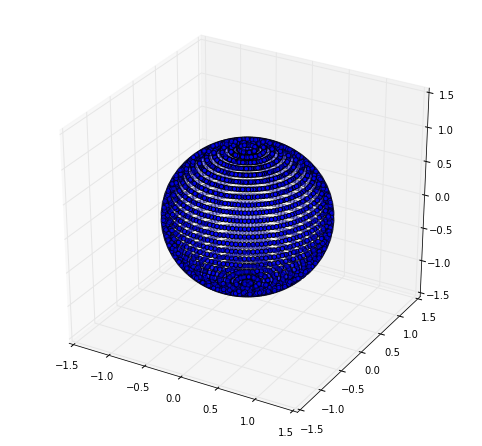

In [364]:
points.plot()

In [365]:
df = pd.DataFrame([[i.calc(0), i.calc(1)] for i in points.verteces], columns = ["f0","f1"])
df['F0'] = df.f0.imag
df['F1'] = df.f1.imag
print(df.F1.sum())

6.24909479438
